# Task Description

We have a list of customers with different features. The target of the document is to divide customers into different segments. Having those, we can create different marketing campaigns for every group and increase our income

# 1. Import needed libraries 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 2. Import and preprocess data

In [3]:
X = pd.read_csv('customer_list.csv')
X.head(), X.shape

(   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
 0           1    Male   19                  15                      39
 1           2    Male   21                  15                      81
 2           3  Female   20                  16                       6
 3           4  Female   23                  16                      77
 4           5  Female   31                  17                      40,
 (200, 5))

We have additional column CustomerID. It should be dropped not to effect on the result of clusterization

In [4]:
X.drop('CustomerID', axis=1, inplace=True)
X.shape

(200, 4)

Describe the dataset

In [5]:
X.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


Make additional preparation to work with data:
- columns names "Annual Income (k$)" and "Spending Score (1-100)" are too long. Change those names
- Make mapping for "Gender" column with numbers

In [6]:
# Change columns names
X=X.rename(columns = {'Annual Income (k$)':'Income', 'Spending Score (1-100)':'Score'})
# Map Gender column 
X['Gender'] = X['Gender'].map({'Male':1, 'Female':2})

In [7]:
X.head()

,Gender,Age,Income,Score
0,1,19,15,39
1,1,21,15,81
2,2,20,16,6
3,2,23,16,77
4,2,31,17,40


# 3. Distribution for data

Create plot distribution for each feature

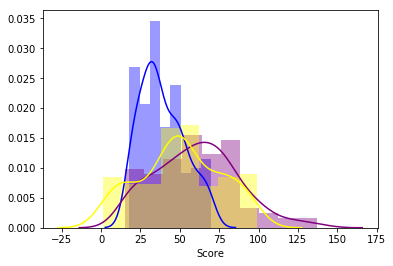

In [8]:
# Distribution for age:
plot_income = sns.distplot(X["Age"], color = 'blue')
# Distribution for income:
plot_spend = sns.distplot(X["Income"], color = 'purple')
# Distribution for score:
plot_spend = sns.distplot(X["Score"], color = 'yellow')

# 4. Select the optimal number of classes

We use Elbow method for it

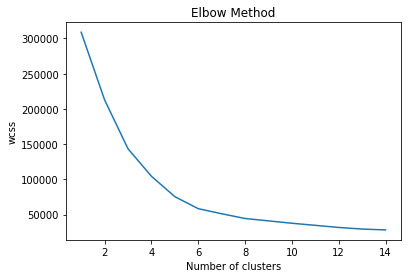

In [9]:
# Optimal number of classes
wcss = []
for i in range(1,15):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,15),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

We see that with a number of clusters 5 or 6, decreasing dispersion is slowing down. Probably, 5 or 6 should be the optimal number of clusters

# 5. Train the model

Firstly, we need to make the composition. We have 4 features:
- Gender
- Age
- Income
- Score

We should transform those in 2 features

In [10]:
from sklearn.cluster import KMeans
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
pca_2d.shape

(200, 2)

Now, we can train the model

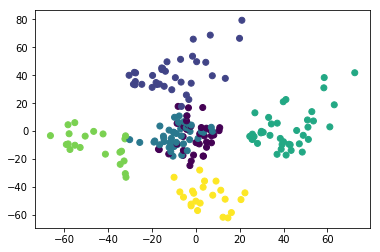

In [11]:
# Train the model with 6 clusters
kmeans = KMeans(n_clusters=6, random_state=111)
kmeans.fit(X)
plt.figure('K-means with 6 clusters')
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
plt.show()

We see that 2 of clusters intersect. It means that better to use 5 clusters.

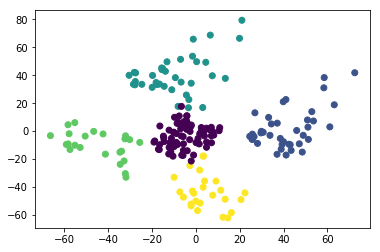

In [12]:
# Train the model with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=111)
kmeans.fit(X)
plt.figure('K-means with 5 clusters')
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
plt.show()

Now, 2 classes that intersect are one class. Probably, 5 clusters are better than 6.

# 6. Define features for segmentation

We have 5 clusters our customers can be divided. Let's define feature characteristic for those classes. 
It allows us to know the evidence that helps in the future prediction to what segment new customer belongs.

Create the matrix, where we have all features and classes.

In [13]:
labels = pd.DataFrame(kmeans.labels_)
data_clust = pd.merge(X, labels, on=X.index, how='outer') 
data_clust.head()

,key_0,Gender,Age,Income,Score,0
0,0,1,19,15,39,3
1,1,1,21,15,81,4
2,2,2,20,16,6,3
3,3,2,23,16,77,4
4,4,2,31,17,40,3


In [14]:
# Drop key_0
data_clust.drop('key_0', axis=1, inplace=True)
# Change name for target column
data_clust=data_clust.rename(columns = {0:'Cluster'})

In [15]:
data_clust.head()

,Gender,Age,Income,Score,Cluster
0,1,19,15,39,3
1,1,21,15,81,4
2,2,20,16,6,3
3,2,23,16,77,4
4,2,31,17,40,3


Define mean, max and min values for columns Age, Income, Score for each of cluster. For Gender define % between male and female

In [17]:
# Create the array of clusters
clust = pd.unique(data_clust['Cluster'])

In [19]:
# Calculation for every Cluster 
for k in clust:
    # Mean age, Mean income, Mean score
    Age_mean = data_clust[data_clust['Cluster']==k]['Age'].mean()
    Income_mean = data_clust[data_clust['Cluster']==k]['Income'].mean()
    Score_mean = data_clust[data_clust['Cluster']==k]['Score'].mean()
    # % between male and female
    Male_percent = data_clust[(data_clust['Cluster']==k) & (data_clust['Gender']==1)]['Gender'].count()\
        /data_clust[data_clust['Cluster']==k]['Gender'].count()
    Female_percent = data_clust[(data_clust['Cluster']==k) & (data_clust['Gender']==2)]['Gender'].count()\
        /data_clust[data_clust['Cluster']==k]['Gender'].count()
    print('Cluster:', k)
    print('Age: %.2f' % Age_mean, 'Income: %.2f' % Income_mean, 'Score: %.2f' % Score_mean,
          'Male_percent: %.2f' % Male_percent, 'Female percent: %.2f' % Female_percent)
    print('------------------------------')

# General values

# Age, Income, Score
Age_mean = data_clust['Age'].mean()
Income_mean = data_clust['Income'].mean()
Score_mean = data_clust['Score'].mean()

# % between male and female
Male_percent = data_clust[data_clust['Gender']==1]['Gender'].count()\
/data_clust['Gender'].count()
Female_percent = data_clust[data_clust['Gender']==2]['Gender'].count()\
/data_clust['Gender'].count()
print('General:')
print('Age: %.2f' % Age_mean, 'Income: %.2f' % Income_mean, 'Score: %.2f' % Score_mean,
          'Male_percent: %.2f' % Male_percent, 'Female percent: %.2f' % Female_percent)

Cluster: 3
Age: 45.22 Income: 26.30 Score: 20.91 Male_percent: 0.39 Female percent: 0.61
------------------------------
Cluster: 4
Age: 24.96 Income: 28.04 Score: 77.00 Male_percent: 0.44 Female percent: 0.56
------------------------------
Cluster: 0
Age: 43.93 Income: 55.21 Score: 49.45 Male_percent: 0.41 Female percent: 0.59
------------------------------
Cluster: 1
Age: 32.69 Income: 86.54 Score: 82.13 Male_percent: 0.46 Female percent: 0.54
------------------------------
Cluster: 2
Age: 40.32 Income: 87.43 Score: 18.19 Male_percent: 0.51 Female percent: 0.49
------------------------------
General:
Age: 38.85 Income: 60.56 Score: 50.20 Male_percent: 0.44 Female percent: 0.56


# 6. Results interpretation

Based on the information above, we can make the next conclusions for each of the clusters (Groups of people):
- Group 1: Its middle is a group (near 45 years) with little income and little score. 60% of the group is Females. It's logical: if the person has little income, it has a little score (do not buy a lot). 
- Group 2: It's young people (near 25 years) with little income and High Score. It's interesting insight: Despite little income, young people spend a lot. 
- Group 3: It's Mid-age people, with middle income and middle score. 
- Group 4. It's people in the age of 30-35 with high income and high score. 
- Group 5. People in the age of 40 (mid-age) with little high income and little score. Those group might be too interesting because, despite high income, they do not spend a lot. 

Additional insights: 
- The younger the person, the more it spends more in the shop. And it does not depend on the income a lot. 
- The older the person, the less it spent. So, people in the mid-age and little income might be not too interesting for us. 

# Conclusion

The most interesting for us might be 2 groups:
- young people with high income. His score is high, but almost the same to the score of young people with little income. We should create some marketing campaign to encourage them to spend more. 
- Mid-age people with high income. They spend very little on the market. So, We also need some campaign to encourage them. It might be some discount programs.